In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch
from torch import nn
from torch.profiler import profiler
from torch.utils.benchmark import Timer, Compare
import torch_fftconv
import matplotlib.pyplot as plt

# Regular Convolution
## Varying input size

[---------------------- Conv2d ---------------------]
                       |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------------
      input size: 64   |        4.0     |      2.6   
      input size: 128  |       32.0     |     17.7   
      input size: 256  |      197.4     |    101.4   
      input size: 512  |     1250.2     |    577.5   

Times are in milliseconds (ms).



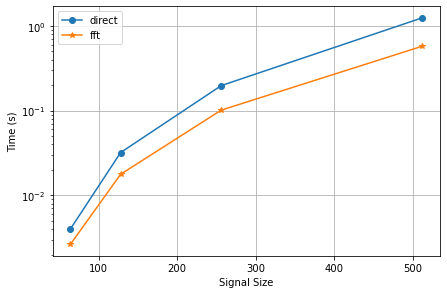

In [3]:
batch = 8
in_channels = 4
out_channels = 4
groups = 1
input_size = [64, 128, 256, 512]
kernel_size = 31
stride = 1
dilation = 1

model1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)
model2 = torch_fftconv.FFTConv2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)

results = []
for i_size in input_size:
    label = 'Conv2d'
    sub_label = f'input size: {i_size}'
    x = torch.ones(batch, in_channels, i_size, i_size)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(input_size, naive_result, marker='o', label='direct')
plt.plot(input_size, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Signal Size')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying kernel size

[---------------------- Conv2d ----------------------]
                        |  naive conv2d  |  fft conv2d
4 threads: -------------------------------------------
      kernel size: 15   |       52.5     |     98.4   
      kernel size: 31   |      173.4     |    100.2   
      kernel size: 63   |     1306.5     |     97.0   
      kernel size: 127  |     2333.8     |     91.1   

Times are in milliseconds (ms).



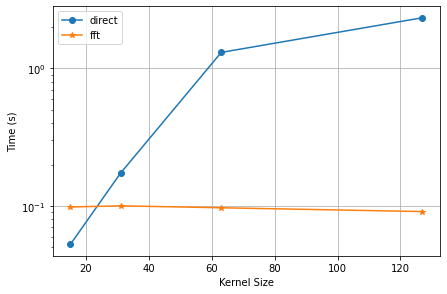

In [4]:
batch = 8
in_channels = 4
out_channels = 4
groups = 1
input_size = 256
kernel_size = [15, 31, 63, 127]
stride = 1
dilation = 1

x = torch.ones(batch, in_channels, input_size, input_size)

results = []
for k_size in kernel_size:
    label = 'Conv2d'
    sub_label = f'kernel size: {k_size}'

    model1 = nn.Conv2d(in_channels, out_channels, k_size, stride=stride, dilation=dilation, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConv2d(in_channels, out_channels, k_size, stride=stride, dilation=dilation, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(kernel_size, naive_result, marker='o', label='direct')
plt.plot(kernel_size, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Kernel Size')
plt.ylabel('Time (s)')
plt.grid()
plt.savefig("images/benchmark_kernel.png", bbox_inches='tight', dpi=100)
#plt.show()

## Varying channel size

[---------------------- Conv2d ----------------------]
                        |  naive conv2d  |  fft conv2d
4 threads: -------------------------------------------
      channel size: 1   |        8.1     |       1.2  
      channel size: 4   |       30.8     |      19.3  
      channel size: 16  |      583.2     |     285.1  
      channel size: 32  |     2240.0     |    1019.9  

Times are in milliseconds (ms).



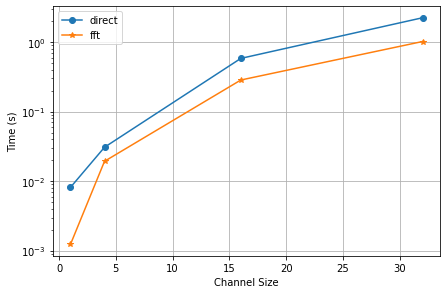

In [5]:
batch = 8
channels = [1, 4, 16, 32]
groups = 1
input_size = 128
kernel_size = 31
stride = 1
dilation = 1


results = []
for chs in channels:
    label = 'Conv2d'
    sub_label = f'channel size: {chs}'
    
    x = torch.ones(batch, chs, input_size, input_size)
    model1 = nn.Conv2d(chs, chs, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConv2d(chs, chs, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(channels, naive_result, marker='o', label='direct')
plt.plot(channels, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Channel Size')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying groups

[------------------- Conv2d ------------------]
                 |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------
      groups: 1  |     2202.6     |    1261.1  
      groups: 2  |     1121.3     |     612.2  
      groups: 4  |      449.5     |     282.9  
      groups: 8  |      518.0     |     200.0  

Times are in milliseconds (ms).



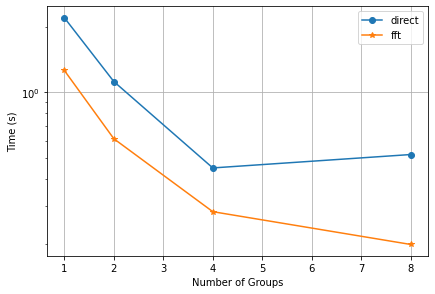

In [6]:
batch = 8
channels = 32
groups = [1, 2, 4, 8]
input_size = 128
kernel_size = 31
stride = 1
dilation = 1

x = torch.ones(batch, channels, input_size, input_size)

results = []
for g in groups:
    label = 'Conv2d'
    sub_label = f'groups: {g}'
    
    model1 = nn.Conv2d(channels, channels, kernel_size, stride=stride, dilation=dilation, groups=g, bias=False)
    model2 = torch_fftconv.FFTConv2d(channels, channels, kernel_size, stride=stride, dilation=dilation, groups=g, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(groups, naive_result, marker='o', label='direct')
plt.plot(groups, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Groups')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying stride

[------------------- Conv2d ------------------]
                 |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------
      stride: 1  |     1274.1     |    511.9   
      stride: 2  |      308.6     |    514.7   
      stride: 3  |      140.2     |    424.1   
      stride: 5  |       55.1     |    399.5   
      stride: 7  |       30.9     |    394.8   

Times are in milliseconds (ms).



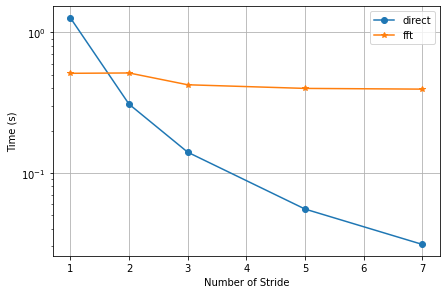

In [7]:
batch = 8
channels = 4
groups = 1
input_size = 512
kernel_size = 31
stride = [1, 2, 3, 5, 7]
dilation = 1

x = torch.ones(batch, channels, input_size, input_size)

results = []
for s in stride:
    label = 'Conv2d'
    sub_label = f'stride: {s}'
    
    model1 = nn.Conv2d(channels, channels, kernel_size, stride=s, dilation=dilation, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConv2d(channels, channels, kernel_size, stride=s, dilation=dilation, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(stride, naive_result, marker='o', label='direct')
plt.plot(stride, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Stride')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying dilation

[-------------------- Conv2d -------------------]
                   |  naive conv2d  |  fft conv2d
4 threads: --------------------------------------
      dilation: 1  |     1261.1     |    464.4   
      dilation: 2  |     1233.2     |    318.1   
      dilation: 3  |     1268.9     |    367.9   
      dilation: 5  |     1134.0     |    337.2   
      dilation: 7  |      954.4     |    348.4   

Times are in milliseconds (ms).



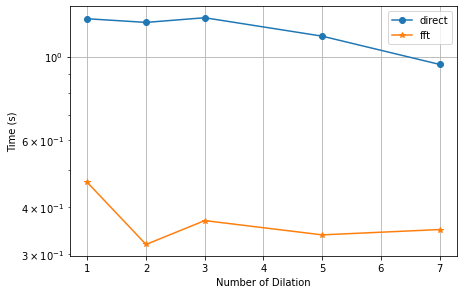

In [8]:
batch = 8
channels = 4
groups = 1
input_size = 512
kernel_size = 31
stride = 1
dilation = [1, 2, 3, 5, 7]

x = torch.ones(batch, channels, input_size, input_size)

results = []
for d in dilation:
    label = 'Conv2d'
    sub_label = f'dilation: {d}'
    
    model1 = nn.Conv2d(channels, channels, kernel_size, stride=stride, dilation=d, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConv2d(channels, channels, kernel_size, stride=stride, dilation=d, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(dilation, naive_result, marker='o', label='direct')
plt.plot(dilation, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Dilation')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

# Transpose Convolution
## Varying input size

[---------------------- Conv2d ---------------------]
                       |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------------
      input size: 32   |       73.2     |      2.4   
      input size: 64   |      400.3     |      9.2   
      input size: 128  |     1615.4     |     35.7   
      input size: 256  |     6270.5     |    142.9   

Times are in milliseconds (ms).



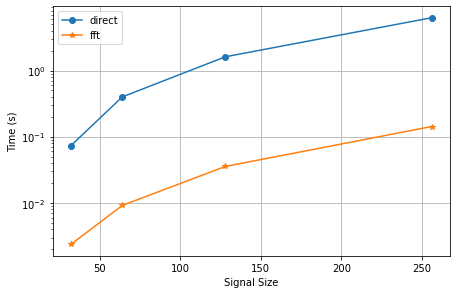

In [9]:
batch = 8
in_channels = 4
out_channels = 4
groups = 1
input_size = [32, 64, 128, 256]
kernel_size = 31
stride = 1
dilation = 1

model1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)
model2 = torch_fftconv.FFTConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)

results = []
for i_size in input_size:
    label = 'Conv2d'
    sub_label = f'input size: {i_size}'
    x = torch.ones(batch, in_channels, i_size, i_size)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(input_size, naive_result, marker='o', label='direct')
plt.plot(input_size, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Signal Size')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying kernel size

[---------------------- Conv2d ---------------------]
                       |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------------
      kernel size: 7   |       59.0     |     24.3   
      kernel size: 15  |      370.4     |     31.0   
      kernel size: 31  |     1540.0     |     34.3   
      kernel size: 63  |     6477.3     |     52.5   

Times are in milliseconds (ms).



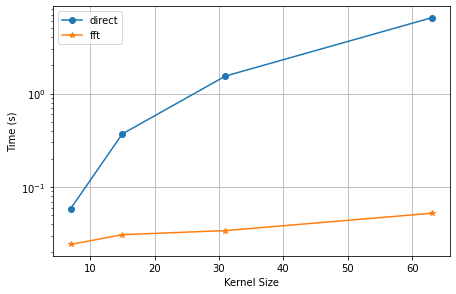

In [10]:
batch = 8
in_channels = 4
out_channels = 4
groups = 1
input_size = 128
kernel_size = [7, 15, 31, 63]
stride = 1
dilation = 1

x = torch.ones(batch, in_channels, input_size, input_size)

results = []
for k_size in kernel_size:
    label = 'Conv2d'
    sub_label = f'kernel size: {k_size}'

    model1 = nn.ConvTranspose2d(in_channels, out_channels, k_size, stride=stride, dilation=dilation, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConvTranspose2d(in_channels, out_channels, k_size, stride=stride, dilation=dilation, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(kernel_size, naive_result, marker='o', label='direct')
plt.plot(kernel_size, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Kernel Size')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying channel size

[---------------------- Conv2d ----------------------]
                        |  naive conv2d  |  fft conv2d
4 threads: -------------------------------------------
      channel size: 1   |      7731.6    |      916.6 
      channel size: 4   |     62005.4    |     4844.1 
      channel size: 16  |    408627.8    |    82290.1 
      channel size: 32  |    751371.8    |   275794.1 

Times are in microseconds (us).



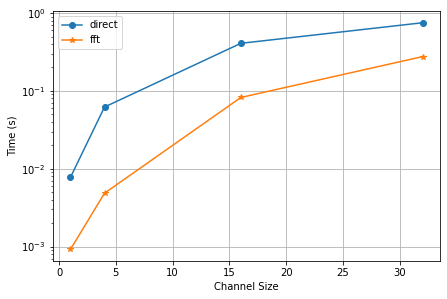

In [11]:
batch = 8
channels = [1, 4, 16, 32]
groups = 1
input_size = 64
kernel_size = 15
stride = 1
dilation = 1


results = []
for chs in channels:
    label = 'Conv2d'
    sub_label = f'channel size: {chs}'
    
    x = torch.ones(batch, chs, input_size, input_size)
    model1 = nn.ConvTranspose2d(chs, chs, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConvTranspose2d(chs, chs, kernel_size, stride=stride, dilation=dilation, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(channels, naive_result, marker='o', label='direct')
plt.plot(channels, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Channel Size')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying groups

[------------------- Conv2d ------------------]
                 |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------
      groups: 1  |     735.7      |    279.3   
      groups: 2  |     810.4      |    170.8   
      groups: 4  |     799.2      |    109.5   
      groups: 8  |     568.8      |     79.9   

Times are in milliseconds (ms).



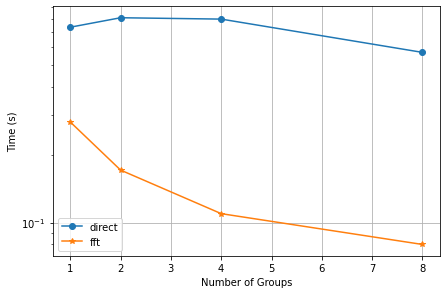

In [12]:
batch = 8
channels = 32
groups = [1, 2, 4, 8]
input_size = 64
kernel_size = 15
stride = 1
dilation = 1

x = torch.ones(batch, channels, input_size, input_size)

results = []
for g in groups:
    label = 'Conv2d'
    sub_label = f'groups: {g}'
    
    model1 = nn.ConvTranspose2d(channels, channels, kernel_size, stride=stride, dilation=dilation, groups=g, bias=False)
    model2 = torch_fftconv.FFTConvTranspose2d(channels, channels, kernel_size, stride=stride, dilation=dilation, groups=g, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(groups, naive_result, marker='o', label='direct')
plt.plot(groups, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Groups')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying stride

[------------------- Conv2d ------------------]
                 |  naive conv2d  |  fft conv2d
4 threads: ------------------------------------
      stride: 1  |     386.8      |     29.4   
      stride: 2  |     387.0      |    111.4   
      stride: 3  |     447.0      |    212.3   
      stride: 5  |     576.1      |    469.4   
      stride: 7  |     713.0      |    962.6   

Times are in milliseconds (ms).



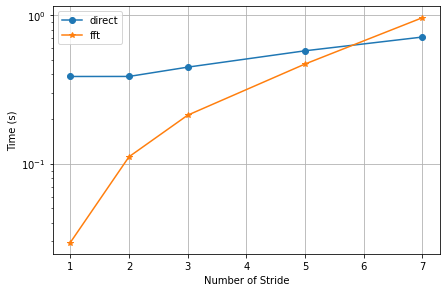

In [13]:
batch = 8
channels = 4
groups = 1
input_size = 128
kernel_size = 15
stride = [1, 2, 3, 5, 7]
dilation = 1

x = torch.ones(batch, channels, input_size, input_size)

results = []
for s in stride:
    label = 'Conv2d'
    sub_label = f'stride: {s}'
    
    model1 = nn.ConvTranspose2d(channels, channels, kernel_size, stride=s, dilation=dilation, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConvTranspose2d(channels, channels, kernel_size, stride=s, dilation=dilation, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(stride, naive_result, marker='o', label='direct')
plt.plot(stride, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Stride')
plt.ylabel('Time (s)')
plt.grid()
plt.show()

## Varying dilation

[-------------------- Conv2d -------------------]
                   |  naive conv2d  |  fft conv2d
4 threads: --------------------------------------
      dilation: 1  |     1628.8     |     35.8   
      dilation: 2  |     1549.9     |     50.1   
      dilation: 3  |     1524.9     |     77.9   
      dilation: 5  |     1529.2     |    118.7   
      dilation: 7  |     1553.9     |    186.6   

Times are in milliseconds (ms).



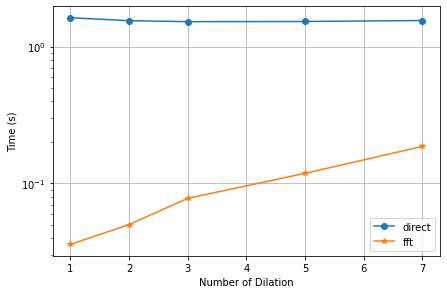

In [14]:
batch = 8
channels = 4
groups = 1
input_size = 128
kernel_size = 31
stride = 1
dilation = [1, 2, 3, 5, 7]

x = torch.ones(batch, channels, input_size, input_size)

results = []
for d in dilation:
    label = 'Conv2d'
    sub_label = f'dilation: {d}'
    
    model1 = nn.ConvTranspose2d(channels, channels, kernel_size, stride=stride, dilation=d, groups=groups, bias=False)
    model2 = torch_fftconv.FFTConvTranspose2d(channels, channels, kernel_size, stride=stride, dilation=d, groups=groups, bias=False)

    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model1},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='naive conv2d',
    ).blocked_autorange(min_run_time=1))
    results.append(Timer(
        stmt='m(x)',
        setup='',
        globals={'x': x, 'm': model2},
        num_threads=4,
        label=label,
        sub_label=sub_label,
        description='fft conv2d',
    ).blocked_autorange(min_run_time=1))

compare = Compare(results)
compare.print()

naive_result = [x.median for x in results[::2]]
fft_result = [x.median for x in results[1::2]]

plt.plot(dilation, naive_result, marker='o', label='direct')
plt.plot(dilation, fft_result, marker='*', label='fft')
plt.tight_layout()
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Dilation')
plt.ylabel('Time (s)')
plt.grid()
plt.show()